In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("spam_dataset.csv", index_col = 0)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [3]:
df['label'].value_counts()

ham     3531
spam    1462
Name: label, dtype: int64

<AxesSubplot:xlabel='label_num', ylabel='count'>

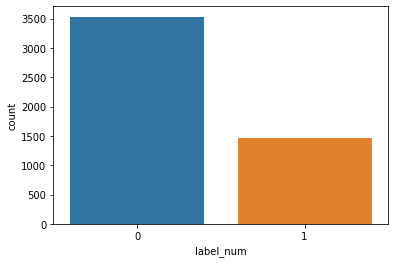

In [4]:
sns.countplot(data=df, x = 'label_num')

In [5]:
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

X = df['text']  
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
TF_Vector = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')

X_train_TF = TF_Vector.fit_transform(X_train)
X_test_TF = TF_Vector.transform(X_test)

In [10]:
log_regr = LogisticRegression().fit(X_train_TF, y_train)

In [11]:
mlp = MLPClassifier().fit(X_train_TF, y_train)

In [15]:
y_pred = log_regr.predict(X_test_TF)
y_pred_train = log_regr.predict(X_train_TF)

In [13]:
y_pred_mlp = mlp.predict(X_test_TF)
y_pred_train_mlp = mlp.predict(X_train_TF)

In [16]:
acc_score = round(accuracy_score(y_test, y_pred)*100,2)
print(f"l'accuracy del modello (test set) è pari a {acc_score}")

l'accuracy del modello (test set) è pari a 99.0


In [17]:
acc_score = round(accuracy_score(y_test, y_pred_mlp)*100,2)
print(f"l'accuracy del modello (test set) è pari a {acc_score}")

l'accuracy del modello (test set) è pari a 98.8


acc_score_train = round(accuracy_score(y_train, y_pred_train)*100,2)
acc_score_train

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       722
        spam       0.98      0.99      0.98       277

    accuracy                           0.99       999
   macro avg       0.99      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999



In [18]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       722
        spam       1.00      0.96      0.98       277

    accuracy                           0.99       999
   macro avg       0.99      0.98      0.98       999
weighted avg       0.99      0.99      0.99       999



Probabilmente qui sarebbe stato meglio scegliere l'MLP se l'obiettivo fosse stato non mancare nemmeno una mail spam per via
della eventuale pericolosità, altrimenti in generale, la regressione logistica ha metriche "mediamente" migliori, 
anche se si discute di inezie.

In [19]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [20]:
df_topic = df.loc[df['label_num'] == 1]

In [21]:
documenti = df_topic["text"]
def sent_to_words(items):
    for item in items:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(item), deacc=True))

def remove_stopwords(texts):
    return [[word for word in words if word not in stop_words and len(word) >=5] for words in texts]

data_words = list(sent_to_words(documenti))
data_words = remove_stopwords(data_words)

In [22]:
import gensim.corpora as corpora 

id2word = corpora.Dictionary(data_words)

corpus = [id2word.doc2bow(text) for text in data_words]

In [25]:
import gensim
from pprint import pprint

num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                        passes  = 15)

topics = lda_model.print_topics()
for topic in topics:
    print(topic)
#doc_lda = lda_model[corpus]

(0, '0.008*"windows" + 0.007*"adobe" + 0.007*"price" + 0.006*"professional" + 0.006*"microsoft" + 0.005*"software" + 0.005*"office" + 0.004*"photoshop" + 0.003*"corel" + 0.003*"macromedia"')
(1, '0.009*"computron" + 0.007*"message" + 0.006*"contact" + 0.005*"please" + 0.004*"reply" + 0.004*"remove" + 0.004*"prices" + 0.003*"click" + 0.003*"email" + 0.003*"special"')
(2, '0.007*"color" + 0.006*"align" + 0.005*"width" + 0.003*"online" + 0.003*"border" + 0.003*"moopid" + 0.003*"hotlist" + 0.003*"click" + 0.003*"order" + 0.003*"rolex"')
(3, '0.012*"company" + 0.008*"statements" + 0.006*"information" + 0.005*"height" + 0.005*"pills" + 0.005*"investment" + 0.005*"within" + 0.005*"report" + 0.005*"stock" + 0.004*"securities"')
(4, '0.003*"email" + 0.003*"viagra" + 0.003*"online" + 0.003*"please" + 0.003*"account" + 0.002*"visit" + 0.002*"cialis" + 0.002*"world" + 0.002*"prescription" + 0.002*"paliourg"')


In [26]:
doc_lda = lda_model[corpus]

In [28]:
df_topic = df_topic.reset_index()
docs_num = []
topics = []
scores = []
for i in range(len(df_topic)):
    topic = id2word.doc2bow(simple_preprocess(df_topic["text"][i]))
    print(f"Documento {i}")
    docs_num.append(i)
    for index, score in lda_model[topic]:
            print("TOPIC: "+str(index))
            print("SCORE:"+str(score)+"\n")
            topics.append(index)
            scores.append(score)
mean_scores = sum(scores)/len(scores)
mean_scores

Documento 0
TOPIC: 0
SCORE:0.074593134

TOPIC: 3
SCORE:0.9108518

Documento 1
TOPIC: 3
SCORE:0.98098415

Documento 2
TOPIC: 3
SCORE:0.998385

Documento 3
TOPIC: 0
SCORE:0.010045377

TOPIC: 1
SCORE:0.93228537

TOPIC: 2
SCORE:0.010046844

TOPIC: 3
SCORE:0.03757026

TOPIC: 4
SCORE:0.010052146

Documento 4
TOPIC: 3
SCORE:0.97940785

Documento 5
TOPIC: 3
SCORE:0.99874777

Documento 6
TOPIC: 3
SCORE:0.9983651

Documento 7
TOPIC: 1
SCORE:0.9959448

Documento 8
TOPIC: 0
SCORE:0.010108004

TOPIC: 1
SCORE:0.010118098

TOPIC: 2
SCORE:0.95930964

TOPIC: 3
SCORE:0.010296762

TOPIC: 4
SCORE:0.010167512

Documento 9
TOPIC: 0
SCORE:0.013464917

TOPIC: 1
SCORE:0.013416555

TOPIC: 2
SCORE:0.014343607

TOPIC: 3
SCORE:0.9453187

TOPIC: 4
SCORE:0.013456181

Documento 10
TOPIC: 0
SCORE:0.9931547

Documento 11
TOPIC: 0
SCORE:0.01749248

TOPIC: 3
SCORE:0.3324491

TOPIC: 4
SCORE:0.64501864

Documento 12
TOPIC: 0
SCORE:0.5282403

TOPIC: 2
SCORE:0.3499827

TOPIC: 3
SCORE:0.11386734

Documento 13
TOPIC: 3
SCORE:0

TOPIC: 0
SCORE:0.015682356

TOPIC: 1
SCORE:0.3893996

TOPIC: 2
SCORE:0.42348018

TOPIC: 3
SCORE:0.15553808

TOPIC: 4
SCORE:0.01589982

Documento 345
TOPIC: 0
SCORE:0.022516206

TOPIC: 1
SCORE:0.02267796

TOPIC: 2
SCORE:0.90835637

TOPIC: 3
SCORE:0.023772942

TOPIC: 4
SCORE:0.022676555

Documento 346
TOPIC: 0
SCORE:0.5431173

TOPIC: 3
SCORE:0.4521112

Documento 347
TOPIC: 4
SCORE:0.99318284

Documento 348
TOPIC: 1
SCORE:0.23621045

TOPIC: 3
SCORE:0.4187754

TOPIC: 4
SCORE:0.32537606

Documento 349
TOPIC: 0
SCORE:0.010744792

TOPIC: 1
SCORE:0.010824894

TOPIC: 2
SCORE:0.010878345

TOPIC: 3
SCORE:0.9565897

TOPIC: 4
SCORE:0.01096222

Documento 350
TOPIC: 2
SCORE:0.9812069

Documento 351
TOPIC: 3
SCORE:0.98856384

Documento 352
TOPIC: 3
SCORE:0.15373337

TOPIC: 4
SCORE:0.84445447

Documento 353
TOPIC: 3
SCORE:0.995498

Documento 354
TOPIC: 2
SCORE:0.73724735

TOPIC: 3
SCORE:0.25489348

Documento 355
TOPIC: 1
SCORE:0.9856413

Documento 356
TOPIC: 3
SCORE:0.9697047

Documento 357
TOPIC: 2
SC

TOPIC: 3
SCORE:0.99878645

Documento 709
TOPIC: 3
SCORE:0.96988446

Documento 710
TOPIC: 1
SCORE:0.98098475

Documento 711
TOPIC: 0
SCORE:0.028637126

TOPIC: 1
SCORE:0.028753467

TOPIC: 2
SCORE:0.029686304

TOPIC: 3
SCORE:0.029839441

TOPIC: 4
SCORE:0.88308364

Documento 712
TOPIC: 2
SCORE:0.9859645

Documento 713
TOPIC: 3
SCORE:0.99863493

Documento 714
TOPIC: 1
SCORE:0.6114761

TOPIC: 2
SCORE:0.18870771

TOPIC: 3
SCORE:0.18121172

Documento 715
TOPIC: 1
SCORE:0.40144822

TOPIC: 2
SCORE:0.44725955

TOPIC: 3
SCORE:0.13654315

Documento 716
TOPIC: 2
SCORE:0.54229015

TOPIC: 3
SCORE:0.43800107

Documento 717
TOPIC: 0
SCORE:0.23584445

TOPIC: 1
SCORE:0.6407291

TOPIC: 3
SCORE:0.12213052

Documento 718
TOPIC: 1
SCORE:0.9658926

Documento 719
TOPIC: 4
SCORE:0.9920454

Documento 720
TOPIC: 0
SCORE:0.3699895

TOPIC: 1
SCORE:0.06774703

TOPIC: 2
SCORE:0.06785876

TOPIC: 3
SCORE:0.06897296

TOPIC: 4
SCORE:0.42543176

Documento 721
TOPIC: 3
SCORE:0.98386925

Documento 722
TOPIC: 0
SCORE:0.918656

TOPIC: 2
SCORE:0.63011014

TOPIC: 3
SCORE:0.36873847

Documento 1031
TOPIC: 3
SCORE:0.9980572

Documento 1032
TOPIC: 3
SCORE:0.9941912

Documento 1033
TOPIC: 0
SCORE:0.015582254

TOPIC: 1
SCORE:0.016150372

TOPIC: 2
SCORE:0.937298

TOPIC: 3
SCORE:0.015496113

TOPIC: 4
SCORE:0.015473287

Documento 1034
TOPIC: 3
SCORE:0.994312

Documento 1035
TOPIC: 4
SCORE:0.9676107

Documento 1036
TOPIC: 0
SCORE:0.10040915

TOPIC: 1
SCORE:0.100719646

TOPIC: 2
SCORE:0.100039765

TOPIC: 3
SCORE:0.10003861

TOPIC: 4
SCORE:0.59879285

Documento 1037
TOPIC: 3
SCORE:0.998574

Documento 1038
TOPIC: 1
SCORE:0.99878204

Documento 1039
TOPIC: 0
SCORE:0.20566958

TOPIC: 3
SCORE:0.7763146

Documento 1040
TOPIC: 0
SCORE:0.022721134

TOPIC: 1
SCORE:0.20726772

TOPIC: 2
SCORE:0.7248454

TOPIC: 3
SCORE:0.022766117

TOPIC: 4
SCORE:0.022399647

Documento 1041
TOPIC: 3
SCORE:0.9895718

Documento 1042
TOPIC: 1
SCORE:0.511591

TOPIC: 3
SCORE:0.47838673

Documento 1043
TOPIC: 0
SCORE:0.82400715

TOPIC: 3
SCORE:0.15405187



TOPIC: 0
SCORE:0.86543447

TOPIC: 4
SCORE:0.13062832

Documento 1385
TOPIC: 0
SCORE:0.58772093

TOPIC: 1
SCORE:0.3335373

TOPIC: 3
SCORE:0.075373344

Documento 1386
TOPIC: 0
SCORE:0.01066662

TOPIC: 1
SCORE:0.95638114

TOPIC: 2
SCORE:0.0108900275

TOPIC: 3
SCORE:0.01099464

TOPIC: 4
SCORE:0.011067638

Documento 1387
TOPIC: 1
SCORE:0.99450254

Documento 1388
TOPIC: 0
SCORE:0.067662895

TOPIC: 1
SCORE:0.7242734

TOPIC: 2
SCORE:0.069197744

TOPIC: 3
SCORE:0.07049476

TOPIC: 4
SCORE:0.06837124

Documento 1389
TOPIC: 1
SCORE:0.99406993

Documento 1390
TOPIC: 3
SCORE:0.9785935

Documento 1391
TOPIC: 1
SCORE:0.9870867

Documento 1392
TOPIC: 0
SCORE:0.86432284

TOPIC: 3
SCORE:0.12858543

Documento 1393
TOPIC: 0
SCORE:0.010635166

TOPIC: 1
SCORE:0.95735025

TOPIC: 2
SCORE:0.010620021

TOPIC: 3
SCORE:0.01078638

TOPIC: 4
SCORE:0.010608152

Documento 1394
TOPIC: 0
SCORE:0.79516906

TOPIC: 1
SCORE:0.050888814

TOPIC: 2
SCORE:0.05330068

TOPIC: 3
SCORE:0.050520148

TOPIC: 4
SCORE:0.05012128

Docume

0.3909054473801828

In [29]:
from gensim.models import Word2Vec
import gensim.downloader

In [30]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [31]:
import string
import spacy
from nltk.corpus import stopwords
import re

english_stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    
    return sentence.split()

In [32]:
import numpy as np
def avg_vector(sentence):
    to_remove = 0
    vector = np.zeros(300)
    for word in sentence:
        if word in glove_vectors.key_to_index.keys():
            vector += glove_vectors.get_vector(word)
        else:
            to_remove += 1
    if len(sentence)== to_remove:
        return np.zeros(300)
        
    return vector/(len(sentence)-to_remove)

In [33]:
vectors = []
sentences  = df_topic["text"]
for sentence in sentences:
    vectors.append(avg_vector(data_cleaner(sentence)))

In [34]:
from scipy import spatial
def most_similar(vectors, index):
    similarity = 0
    index_similar_doc = 0
    for i in range(0,len(vectors)):
        if i!=index and vectors[i].all()!=np.zeros(300).all():
            if 1 - spatial.distance.cosine(vectors[index], vectors[i]) > similarity:
                index_similar_doc = i
                similarity = 1 - spatial.distance.cosine(vectors[index], vectors[i])
    
    return similarity,index_similar_doc

In [39]:
1 - spatial.distance.cosine(vectors[6], vectors[100])

0.2548320150330896

vectors[6], vectors[100]

In [41]:
df_no_spam = df.loc[df['label_num'] == 0]

In [42]:
from spacy import displacy 

vettori = [avg_vector(data_cleaner(doc)) for doc in df_no_spam["text"]]

In [43]:
def display_spacy_result (n):
    sentence = df_no_spam["text"].iloc[n]
    doc = nlp(sentence)
    return displacy.serve(doc, style = "ent")

In [52]:
list_ents = document.ents
list_ents

(9 / 00,
 02 / 15 / 2001 01,
 40 pm,
 megan parker / corp / enron,
 9 / 00,
 enron north america corp .,
 megan parker,
 02 / 15 / 2001 01,
 09,
 9 / 00,
 sept 2000,
 157288,
 8,
 745,
 69)

In [62]:
def entity_org(document):
    return [i for i in (nlp(document)).ents if i.label_ == "ORG"]
sentence = df_no_spam["text"].iloc[5]
document = nlp(sentence)
entity_org(document)

[foot locker canada]

In [44]:
result = display_spacy_result(200)

C:\Users\Utente\AppData\Local\Programs\Python\Python310\lib\site-packages\spacy\displacy\__init__.py:103: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [43]:
df_no_spam["text"][200]

"Subject: tech - support @ service . juno . com : problems retrieving mail\ndaren i guess i need help with this too ! love you\n- - - - - - - - - begin forwarded message - - - - - - - - - -\nfrom : tech - support @ service . juno . com\nto :\nsubject : problems retrieving mail\ndate :\nmessage - id :\ndear juno member ,\nyou have received messages with attachments which have not yet been\ndownloaded to your computer . because the version of juno software you\nare currently using is not capable of handling attachments , these\nmessages are still waiting for you on our server . these messages may\nfill your mailbox to its maximum capacity , preventing your account from\nreceiving new mail .\nin order to receive the attachments , you will need to upgrade your juno\nsoftware to version 4 . 0 . in addition to allowing you to retrieve all\nyour messages , this new version carries many enhancements which you will\nfind particularly useful when sending and receiving e - mail .\nif you have acc